In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import os
# Get current case (current directory)
case = os.path.basename(os.getcwd())
print(case)

tjet_Le1B_LGLE


In [9]:
# Load in ODT data
ODT_Tvals = np.loadtxt(r'./T_ODT.txt')
ODT_COvals = np.loadtxt(r'./CO_ODT.txt')
ODT_OHvals = np.loadtxt(r'./OH_ODT.txt')
ODT_CO2vals = np.loadtxt(r'./CO2_ODT.txt')
ODT_hrvals = np.loadtxt(r'./hr_ODT.txt')
ODT_xs = np.loadtxt(r'./xVals.txt')
ODT_ts = np.loadtxt(r'./tVals.txt')

xx,tt = np.meshgrid(ODT_xs,ODT_ts[:39])

# Load in queried data
Tqueried = np.loadtxt(r'./Tqueried.txt')
COqueried = np.loadtxt(r'./COqueried.txt')
OHqueried = np.loadtxt(r'./OHqueried.txt')
CO2queried = np.loadtxt(r'./CO2queried.txt')
hrqueried = np.loadtxt(r'./hrqueried.txt')

# Function for plotting
def figure(odtdata, apdata, phi = "phi", units='units', maxError = None):
    print(f"CASE = {case}")

    tick_locator = ticker.MaxNLocator(nbins=7)

    # Plot direct comparison
    plt.rcParams.update({'font.size': 14})
    fig=plt.figure(figsize=(8,8))
    ax = plt.subplot(1, 2, 1)
    ax.set_title("ODT")
    contour1 = ax.contourf(xx,tt,odtdata.T,100, cmap='inferno')
    levels = contour1.levels
    ax.set_xlabel('x (m)')
    ax.set_ylabel('t (s)')
    ax=plt.subplot(1, 2, 2)
    ax.set_title("Table-queried")
    contour2 = ax.contourf(xx, tt, apdata.T, 100, cmap = 'inferno', levels = levels)
    ax.set_xlabel('x (m)')
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.7])
    cbar = fig.colorbar(contour2, cax=cbar_ax)
    cbar.set_label(f'{phi} ({units})', rotation=270, labelpad=20)
    #cbar.locator = tick_locator
    #cbar.update_ticks()
    plt.show();

    print(f'CASE = {case}')

    # Plot error plot
    fig=plt.figure(figsize=(5,8))
    ax = plt.subplot(1, 1, 1)
    ax.set_title(rf"Error ($\frac{{|\Delta|}}{{\bar{{\phi_{{odt}}}}}}$)")
    errs = odtdata.T - apdata.T
    relErrs = np.abs(errs/np.mean(odtdata.T))*100
    if maxError:
        levels = np.linspace(0, maxError, 101)
        contour = ax.contourf(xx,tt,relErrs, 100, cmap='inferno', levels = levels)
    else:
        contour = ax.contourf(xx,tt,relErrs, 100, cmap='inferno')
    cbar = plt.colorbar(contour, ax = ax)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label(rf'% Error', rotation=270, labelpad=20)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('t (s)')
    plt.tight_layout()
    plt.show();

# Temperature

CASE = tjet_Le1B_LGLE


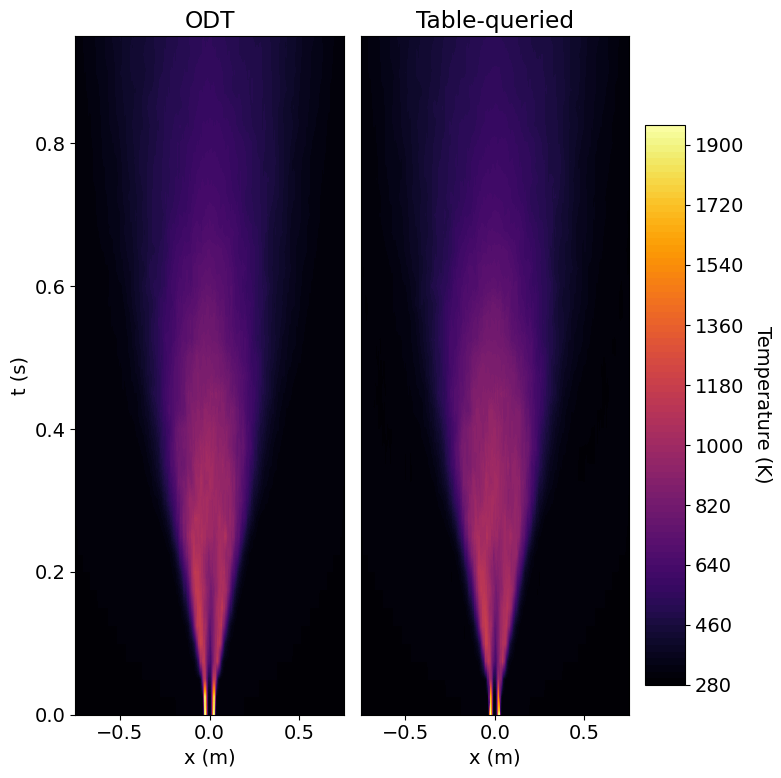

CASE = tjet_Le1B_LGLE


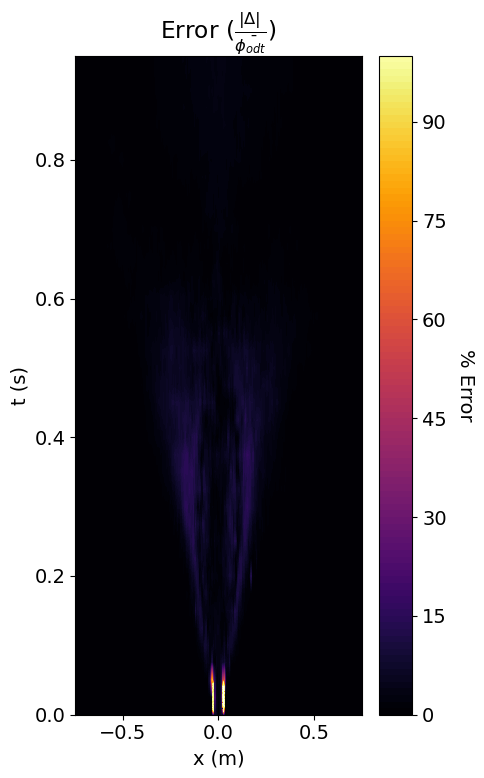

In [10]:
figure(ODT_Tvals, Tqueried, "Temperature", "K", maxError = 100)

# CO

CASE = tjet_Le1B_LGLE


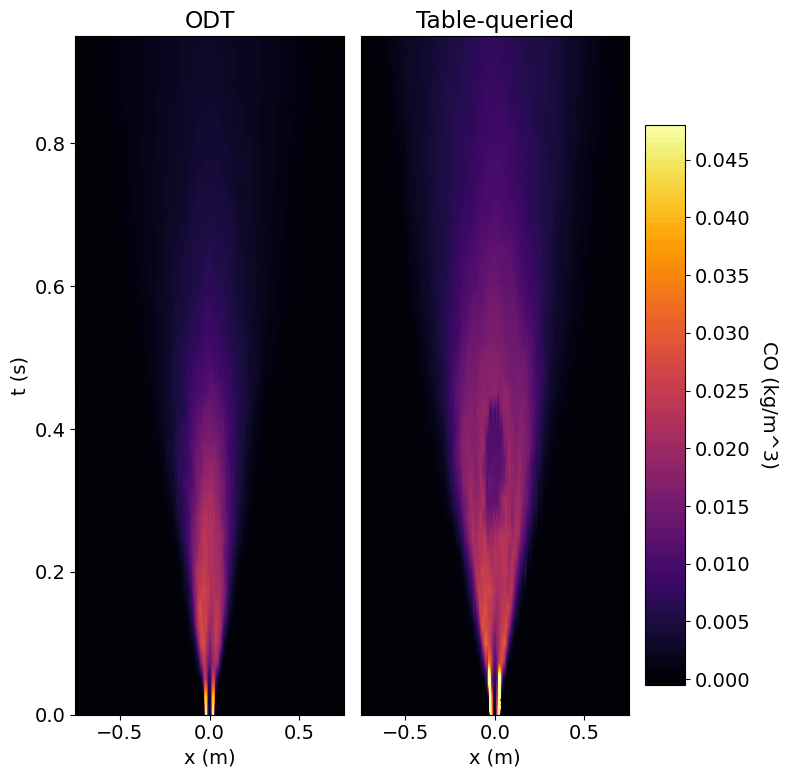

CASE = tjet_Le1B_LGLE


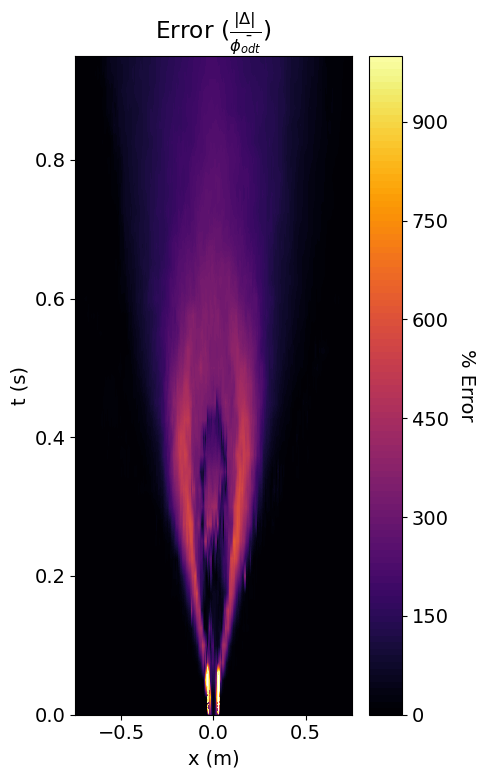

In [11]:
figure(ODT_COvals, COqueried,  "CO", "kg/m^3", maxError = 1000)

# CO2

CASE = tjet_Le1B_LGLE


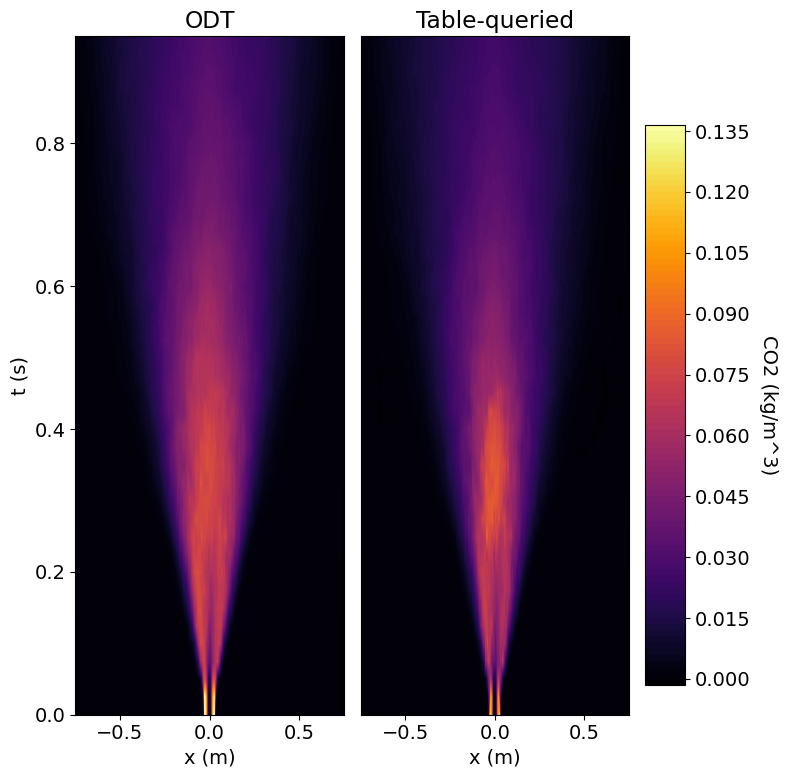

CASE = tjet_Le1B_LGLE


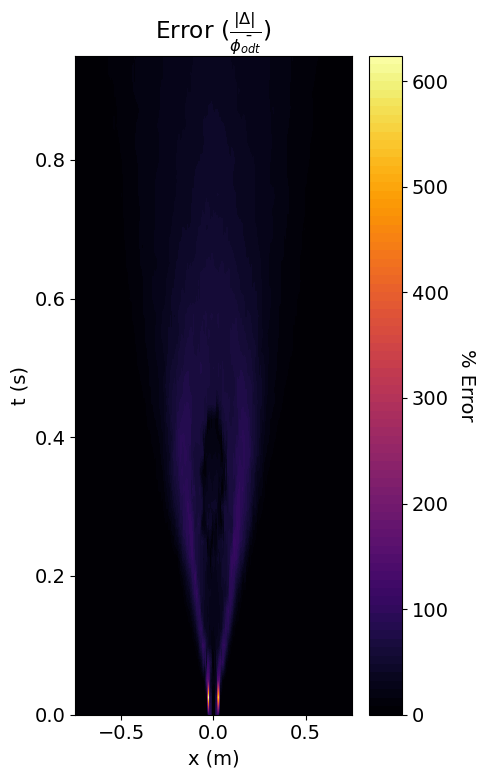

In [12]:
figure(ODT_CO2vals, CO2queried, "CO2", "kg/m^3")

# OH

CASE = tjet_Le1B_LGLE


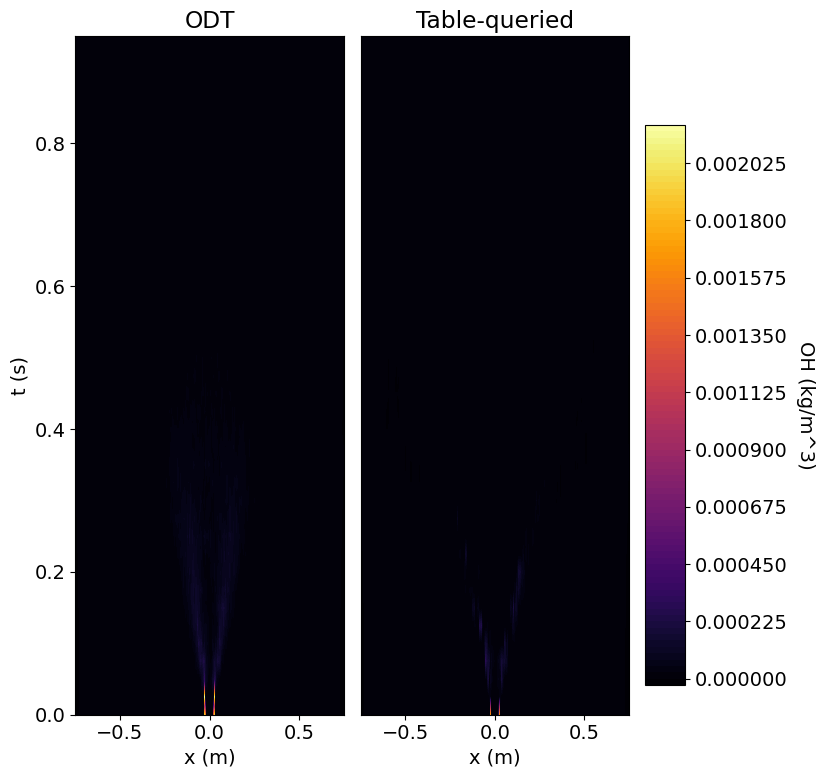

CASE = tjet_Le1B_LGLE


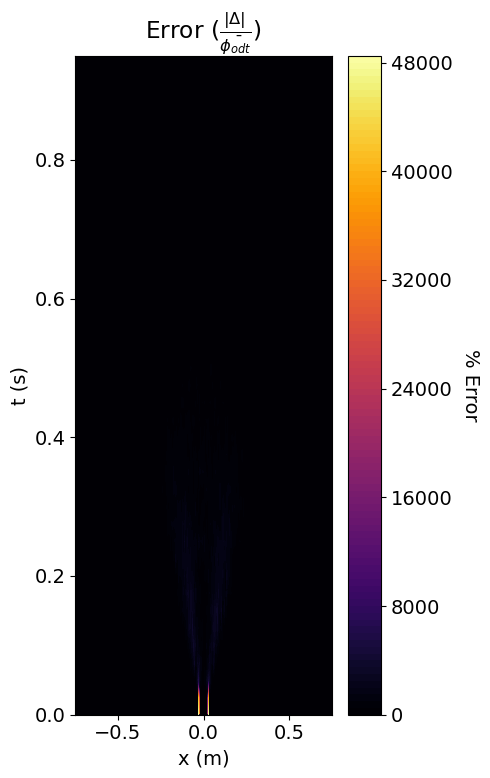

In [13]:
figure(ODT_OHvals, OHqueried, "OH", "kg/m^3")

CASE = tjet_Le1B_LGLE


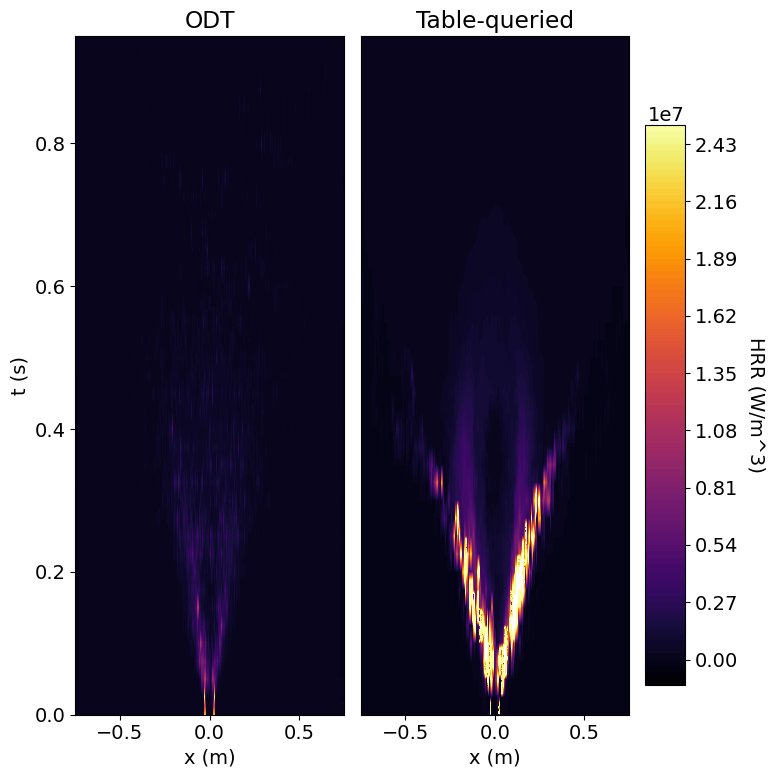

CASE = tjet_Le1B_LGLE


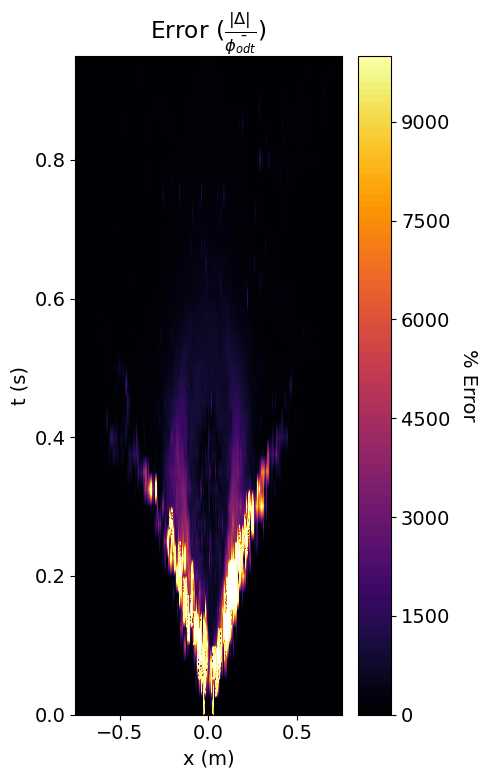

In [14]:
figure(ODT_hrvals, hrqueried, "HRR", "W/m^3", maxError = 1e4)